In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import nltk
import matplotlib.pyplot as plt
import pandas as pd

# Läs in data

I det här fallet har vi valt att ta in data från Excel (eller något motsvarande där datan finns i en fil). Datan innehåller artiklar med titlar inom data science, maskinlärning och artificiell intelligens.

In [29]:
# Read Excel file or .csv file
papers = pd.read_csv('papers.csv')

# Display first five rows
papers.head(5)

,id,year,title,event_type,pdf_name,abstract,paper_text
0,1,1987,Self-Organization of Associative Database and ...,NaN,1-self-organization-of-associative-database-an...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...
1,10,1987,A Mean Field Theory of Layer IV of Visual Cort...,NaN,10-a-mean-field-theory-of-layer-iv-of-visual-c...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...
2,100,1988,Storing Covariance by the Associative Long-Ter...,NaN,100-storing-covariance-by-the-associative-long...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...
3,1000,1994,Bayesian Query Construction for Neural Network...,NaN,1000-bayesian-query-construction-for-neural-ne...,Abstract Missing,Bayesian Query Construction for Neural\nNetwor...
4,1001,1994,"Neural Network Ensembles, Cross Validation, an...",NaN,1001-neural-network-ensembles-cross-validation...,Abstract Missing,"Neural Network Ensembles, Cross\nValidation, a..."


# Processering
Inom datahantering i allmänhet och textanalys i synnerhet, följer man ett tämligen fast flöde av processering av datan. 

1. *Punktuering*: Ta bort all punktuering
2. *Tokenisering*: Gör om en text till en lista med ord
3. *Stopp-ord*: Ta bort vanligt förekommande ord

I vårt fall skall vi också göra

- *Lemmatisering*: Gör om ord till sin oböjda grundform
- *Sammansättningar*: Ser till att kända sammansättningar räknas som ett ord

## Punktuering
Det är heller inte intressant med punktuering, och dessa har också relativt hög frekvens, och bör tas bort. I vårt fall använder vi ett såkallat regelbundet uttryck (regular expression)

In [108]:
import re

regex = '[:,\.!?+]' # Innehåller de punktuationer vi vill ta bort

# Ta bort punktuering
papers['filtered title'] = papers['title'].map(lambda row: re.sub(regex, '', row))

# Byt ut snedstrek mot mellanslag
papers['filtered title'] = papers['filtered title'].map(lambda row: re.sub('[/]', ' ', row))
papers['filtered title'] = papers['filtered title'].map(lambda row: re.sub('[-]', '_', row))

## Tokenisering
Tokenisering avser att man delar upp strängar av text i ord eller andra betydelsebärande enheter. Exempelvis blir ``The quick brown fox jumps over the lazy dog`` tokeniserat som

``
 (sentence
   (word The)
   (word quick)
   (word brown)
   (word fox)
   (word jumps)
   (word over)
   (word the)
   (word lazy)
   (word dog))
``

Vi passar också på att göra om alla ord till gemener.

In [109]:
from nltk import word_tokenize

# Dela upp i ord
papers['filtered title'] = papers['filtered title'].map(lambda row: word_tokenize(row))

# Gör om till gemener
papers['filtered title'] = papers['filtered title'].map(lambda row: [word.lower() for word in row])

## Lemmatisering
I lemmatisering så skrivs ord om till sin mest grundläggande, oböjda form. Exempelvis försvinner pluralis-former och verbböjningar blir infinitiv. Detta för att vi inte ska göra skillnad på om man talar om "network" eller "networks".

In [110]:
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

# Gör om till oböjd form
papers['filtered title'] = papers['filtered title'].map(lambda row: [lemmatizer.lemmatize(word) for word in row])

## Stopp-ord
Stopp-ord är vanligt förekommande ord i ett språk som oftast inte tillför mycket abstrakt mening till en text, speciellt inte i termer av fjärrläsning. Dessa brukar sorteras bort, eftersom de ofta är överväldigande många fler än ämnesorden.

In [111]:
# Vi importerar stopp-orden från nltk
stopwords = nltk.corpus.stopwords.words('english')

# Lägg till några stopp-ord vi vet är vanliga
stopwords.extend(["based", "using", "via"])

# Detta tar bort vanliga datorkaraktärer som inte människor kan läsa (exempelvis "ny rad")
escapes = ''.join([chr(char) for char in range(1, 32)])

print(stopwords)

papers['filtered title'] = papers['filtered title'].map(lambda row: [word for word in row if word not in stopwords])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

## Sammansättningar
I vissa språk, som engelska, måste man vara noggrann med att vissa ord existerar tillsammans med andra som sammansättningar, även om det är ett mellanslag emellan. Detta problem finns sällan på svenska, där vi skriver ihop.



In [112]:
from nltk.tokenize import MWETokenizer

# Vi lägger manuellt till några kända sammansättningar i texterna
compounds = [("artificial", "intelligence"), 
            ("data", "science"), 
            ("neural", "network"), 
            ("gradient", "descent"), 
            ("mean", "field"), 
            ("cross", "validation"),
            ("neural", "net"),
            ("reinforcement", "learning"),
            ("machine", "learning"),
            ("bayesian", "inference"),
            ("bayesian", "analysis"),
            ("random", "process"),
            ("gaussian", "process")]

compounder = MWETokenizer(compounds)
papers['filtered title'] = papers['filtered title'].map(lambda row: compounder.tokenize(row))

In [113]:
# Sammantaget

# papers['filtered title'] = (papers['title'].map(lambda row: re.sub(regex, '', row))
#                                            .map(lambda row: word_tokenize(row))
#                                            .map(lambda row: [word.lower() for word in row])
#                                            .map(lambda row: [lemmatizer.lemmatize(word) for word in row] )
#                                            .map(lambda row: compounder.tokenize(row))
#                                            .map(lambda row: [word for word in row if word not in stopwords])
#                            )

In [114]:
papers['filtered title']

0       [self_organization, associative, database, app...
1       [mean_field, theory, layer, iv, visual, cortex...
2       [storing, covariance, associative, long_term, ...
3       [bayesian, query, construction, neural_network...
4       [neural_network, ensemble, cross_validation, a...
                              ...                        
7236             [single, transistor, learning, synapsis]
7237    [bias, variance, combination, least, square, e...
7238       [real, time, clustering, cmos, neural, engine]
7239    [learning, direction, global, motion, two, cla...
7240    [correlation, interpolation, network, real_tim...
Name: filtered title, Length: 7241, dtype: object

# Instansfördelningar
Vi kan nu börja göra faktisk analys av datan! Ett enkelt men viktigt verktyg är instansfördelningar. Vi gör om hela vår databas till en lång lista med ord och beräkna hur många av varje som finns.

In [115]:
word_counts = papers['filtered title'].explode().value_counts()

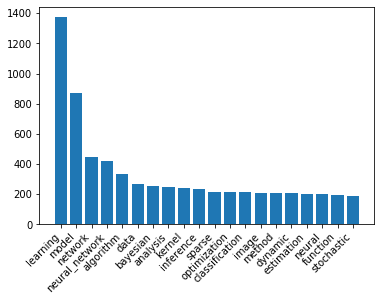

In [116]:
import matplotlib.pyplot as plt

plt.bar(word_counts.index[0:20], word_counts[0:20])
plt.xticks(rotation=45, ha='right')
plt.show()

In [122]:
from nltk import ngrams
grams = papers['filtered title'].map(lambda row: [", ".join(gram) for gram in ngrams(row, 3)]).explode().value_counts()

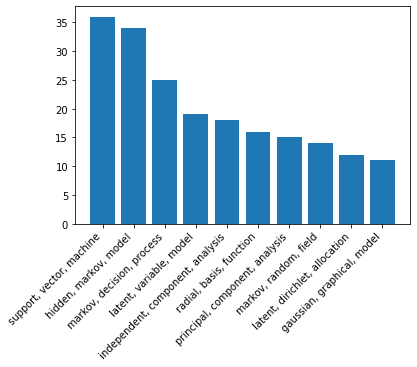

In [199]:
plt.bar(grams.index[0:10], grams[0:10])
plt.xticks(rotation=45, ha='right')
plt.show()

In [137]:
import gensim

model = gensim.models.Word2Vec([list(papers['filtered title'].explode().values)], min_count = 1,  
                              size = 100, window = 5)

In [198]:
print(model.similarity("random", "process"))

0.6051054


In [201]:
import numpy as np    
similarity_matrix = np.dot(model.wv.syn0norm, model.wv.syn0.T)

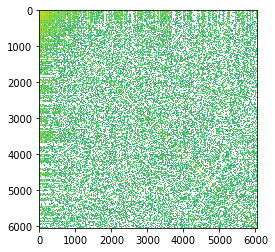

In [207]:
plt.imshow(np.log(similarity_matrix))

In [210]:
similarity_matrix.argsort().shape

(6040, 6040)